In [325]:
import numpy as np
from scipy import ndimage
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import math

In [326]:
def read_images(image_path):
    img = cv2.imread(image_path)
    img  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(float)/255
    return img

### Scale Space by increasing Sigma

In [327]:
def  generate_scale_space(image, initial_sigma, constant_multiplier, iterations):
    current_sigma = initial_sigma
    height = image.shape[0]
    width = image.shape[1]
    scale_space = np.empty((height, width, iterations))
    sigma_values = []
    for i in range(0, iterations):
        sigma_values.append(current_sigma)
        LoG_response = ndimage.gaussian_laplace(image, current_sigma,mode="nearest")
        sigma_normalized_LoG =  np.square(current_sigma) * LoG_response
        scale_space[:,:,i] = np.square(sigma_normalized_LoG)
        current_sigma = math.ceil(constant_multiplier * current_sigma)

    return scale_space, sigma_values

#### Suppress across 2D slices and 3D scale space

In [328]:
def non_maximum_suppression(scale_space, window_size):
    suppressed_space = ndimage.rank_filter(scale_space,rank=-1, footprint=np.ones((window_size,window_size,1)))
    suppressed_space = scale_space * (np.array(suppressed_space == scale_space).astype(int))
    return suppressed_space

def non_maximum_sup_scale_space(scale_space):
    suppressed_space = np.empty((scale_space.shape[0],scale_space.shape[1],scale_space.shape[2]))
    for i in range(scale_space.shape[2]):
         y = ndimage.rank_filter(scale_space[:,:,max(0,i-2):min(scale_space.shape[2],i+3)], rank=-1, size=(9,9,min(scale_space.shape[2],i+3)-max(0,i-2)+1))
         suppressed_space[:,:,i] = y[:,:,-1]

    new_suppressed_scale_space = scale_space *  (np.array(suppressed_space == scale_space).astype(int))

    return new_suppressed_scale_space

#### Initialize Values

In [329]:
constant_scale_factor = 1.25
initial_sigma = 2
image_path = 'sunflowers.jpg'
img = read_images(image_path)
suppress_window = 5
threshold = .0109

#### Apply scale space blob detection logic

In [330]:
scale_space, sigma_values = generate_scale_space(img , initial_sigma, constant_scale_factor, 15 )
suppressed_responses = non_maximum_suppression(scale_space, suppress_window)
suppressed_sp = non_maximum_sup_scale_space(suppressed_responses)
coordinates = np.where(suppressed_sp > threshold)

In [331]:
def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, (pow(constant_scale_factor,rad) * initial_sigma)):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    plt.show()

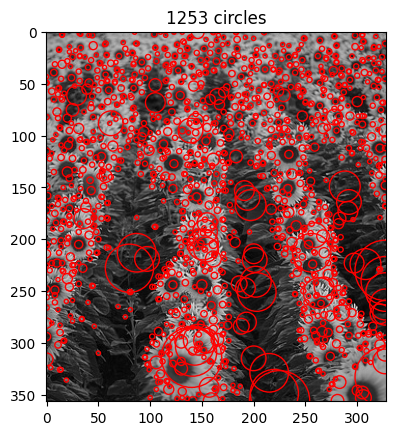

In [332]:
show_all_circles(read_images(image_path),coordinates[1],coordinates[0],coordinates[2])